In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv('../data/online-v0-prolific-sample-130.csv')
df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q_attn_midway,Q_reduce_meat,Q_demos_age,Q_demos_gender,Q_demos_income,Q_demos_race,Q_comments,PROLIFIC_PID,STUDY_ID,treatment
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,Do you want to help us find out who is paying ...,Do you ever reduce meat consumption on the bas...,How old are you?,What is your gender?,What was your total household income before ta...,Choose one or more races that you consider you...,Any extra comments? (optional),PROLIFIC_PID,STUDY_ID,treatment
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""recipientLastName""}",...,"{""ImportId"":""QID56""}","{""ImportId"":""QID53""}","{""ImportId"":""QID30""}","{""ImportId"":""QID57""}","{""ImportId"":""QID25""}","{""ImportId"":""QID24""}","{""ImportId"":""QID58_TEXT""}","{""ImportId"":""PROLIFIC_PID""}","{""ImportId"":""STUDY_ID""}","{""ImportId"":""treatment""}"
2,2022-06-12 16:12:09,2022-06-12 16:12:26,0,*******,100,16,1,2022-06-12 16:12:26,R_3QVIXPx1zfkZNWH,*******,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5c818f0d4f23cf000132ad6f,62a6647d859008af5141202e,NaN
3,2022-06-12 16:12:44,2022-06-12 16:14:57,0,*******,100,133,1,2022-06-12 16:14:57,R_3I4OtkJA2u88n7O,*******,...,5,1,3,1,4,1,NaN,628d114b1acd87ea1b37874e,62a6647d859008af5141202d,unlabeled
4,2022-06-12 16:13:28,2022-06-12 16:15:12,0,*******,100,103,1,2022-06-12 16:15:12,R_3il2zP80lXOBuK5,*******,...,5,2,3,1,6,1,that one attention check to select both was du...,5c8e72856243bb0001dcdea2,62a6647d859008af5141202d,labeled


In [3]:
print(list(df.columns))

['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress', 'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId', 'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'UserLanguage', 'ProlificID ', 'Q_attn_1', 'Q_attn_2', 'Q_pasta_1_unlabeled', 'Q_pasta_2_unlabeled', 'Q_pasta_3_unlabeled', 'Q_pasta_4_unlabeled', 'Q_pasta_5_unlabeled', 'Q_sandwich_1', 'Q_sandwich_2', 'Q_sandwich_3', 'Q_sandwich_4', 'Q_sandwich_5', 'Q_pasta_1_labeled', 'Q_pasta_2_labeled', 'Q_pasta_3_labeled', 'Q_pasta_5_labeled', 'Q_pasta_6_labeled', 'Q_sandwich_1_labeled', 'Q_sandwich_2_labeled', 'Q_sandwich_3_labeled', 'Q_sandwich_4_labeled', 'Q_sandwich_5_labeled', 'Q_attn_check', 'Q_current_hunger', 'Q_urban', 'Q_politics', 'Q_priorities_1', 'Q_priorities_4', 'Q_priorities_5', 'Q_priorities_6', 'Q_priorities_7', 'Q_special_diet', 'Q_special_diet_6_TEXT', 'Q_past_vegetarian', 'Q_past_vegan', 'Q_recent_meal_veget'

Data fixups

In [4]:
"""
Oops! 
Q_pasta_5_labeled should be Q_pasta_4_labeled
Q_pasta_6_labeled should be Q_pasta_5_labeled
"""
if 'Q_pasta_6_labeled' in df.columns:
    print('renaming Q_pasta_5_labeled, Q_pasta_6_labeled')
    df = df.rename(columns={'Q_pasta_5_labeled': 'Q_pasta_4_labeled'})
    df = df.rename(columns={'Q_pasta_6_labeled': 'Q_pasta_5_labeled'})

renaming Q_pasta_5_labeled, Q_pasta_6_labeled


## Data preprocessing


Transform into 3 tables:

0. Codebook

Maps column names to questions/descriptive text


1. Respondent data table:

Contains all relevant non-choice data for a respondent

2. Menu choices table

```
ResponseId, labeled, QID, menu (sandwich/pata), comparison type (1-5), choice (1,2) 
```

In [5]:
# extract the columns we use
respondent_columns = [
    'ResponseId', 'PROLIFIC_PID', 'Finished',
    'Duration (in seconds)', 'RecordedDate',
    'Q_attn_1', 'Q_attn_2', 'Q_attn_check', 'Q_attn_midway', 
    'Q_current_hunger', 'Q_urban', 'Q_politics', 
    'Q_priorities_1', 'Q_priorities_4', 'Q_priorities_5', 'Q_priorities_6', 'Q_priorities_7',
    'Q_special_diet', 'Q_special_diet_6_TEXT', 
    'Q_past_vegetarian', 'Q_past_vegan', 'Q_recent_meal_veget', 'Q_recent_meal_vegan',
    'Q_vegetarian_not_me', 'Q_vegan_not_me', 'Q_good_for_env', 'Q_how_important_env', 'Q_reduce_meat', 
    'Q_demos_age', 'Q_demos_gender', 'Q_demos_income', 'Q_demos_race', 
    'Q_comments',
    'treatment'
]

In [6]:
choice_Q_prefix = ['Q_pasta', 'Q_sandwich']
choice_Qs = [q for q in df.columns if any([q.startswith(p) for p in choice_Q_prefix])]
# choice_Qs

### Codebook

In [7]:
"""
Codebook
QID, text
"""
codebook_df = df[respondent_columns + choice_Qs].iloc[0].rename('text').to_frame()
codebook_df.head(10)

,text
ResponseId,Response ID
PROLIFIC_PID,PROLIFIC_PID
Finished,Finished
Duration (in seconds),Duration (in seconds)
RecordedDate,Recorded Date
Q_attn_1,Please enter the number you see here into the ...
Q_attn_2,Help us keep track of who is paying attention....
Q_attn_check,Which item would you prefer?
Q_attn_midway,Do you want to help us find out who is paying ...
Q_current_hunger,How would you rank your current hunger level o...


### Respondent table

In [8]:
respondent_df = df.drop([0,1])[respondent_columns]
starting_respondent_N = respondent_df['ResponseId'].nunique()
print('N=%s total responses before data cleaning' % starting_respondent_N)
respondent_df.head(3)

N=130 total responses before data cleaning


,ResponseId,PROLIFIC_PID,Finished,Duration (in seconds),RecordedDate,Q_attn_1,Q_attn_2,Q_attn_check,Q_attn_midway,Q_current_hunger,...,Q_vegan_not_me,Q_good_for_env,Q_how_important_env,Q_reduce_meat,Q_demos_age,Q_demos_gender,Q_demos_income,Q_demos_race,Q_comments,treatment
2,R_3QVIXPx1zfkZNWH,5c818f0d4f23cf000132ad6f,1,16,2022-06-12 16:12:26,21,6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R_3I4OtkJA2u88n7O,628d114b1acd87ea1b37874e,1,133,2022-06-12 16:14:57,21,5,"1,2",5,4,...,5,3,5,1,3,1,4,1,NaN,unlabeled
4,R_3il2zP80lXOBuK5,5c8e72856243bb0001dcdea2,1,103,2022-06-12 16:15:12,21,5,2,5,2,...,3,2,4,2,3,1,6,1,that one attention check to select both was du...,labeled


In [9]:
# only include completed surveys
N_uncompleted = len(respondent_df[respondent_df['Finished'] != '1'])
respondent_df = respondent_df[respondent_df['Finished'] == '1']
print('dropping %s incomplete responses' % N_uncompleted)

dropping 1 incomplete responses


In [10]:
def passed_attn_checks(row):
    if row['PROLIFIC_PID'] == '5589a860fdf99b11b2d0404d': # they DM'd to say they fat fingered last attn check
        return True
    if int(row['Q_attn_1']) != 21:
        print(row['ResponseId'], 'failed Q_attn_1')
        return False
    if int(row['Q_attn_2']) != 5:
        print(row['ResponseId'], 'failed Q_attn_2')
        return False
    if row['Q_attn_check'] != '1,2':
        print(row['ResponseId'], 'failed Q_attn_check')
        return False
    if int(row['Q_attn_midway']) != 5:
        print(row['ResponseId'], 'failed Q_attn_midway')
        return False
    return True

In [11]:
respondent_df['passed_attn_checks'] = respondent_df.apply(passed_attn_checks, axis=1)
passed_attn_checks_ResponseId_list = list(respondent_df[respondent_df.passed_attn_checks == True].ResponseId)
print('%s/%s respondents passed all attention checks' % (len(passed_attn_checks_ResponseId_list), len(respondent_df)))
passed_attn_checks_ResponseId_list

R_3QVIXPx1zfkZNWH failed Q_attn_2
R_3il2zP80lXOBuK5 failed Q_attn_check
R_PvXWPrLkXyhJjxf failed Q_attn_2
R_1kTuAvHs1eI18ko failed Q_attn_2
R_2PnhjASWnDceNtA failed Q_attn_2
R_2CUMXBtM9T9891B failed Q_attn_check
R_1QE4d9AOcRg1vSu failed Q_attn_2
122/129 respondents passed all attention checks


['R_3I4OtkJA2u88n7O',
 'R_2azWqLxVBzcA2KZ',
 'R_10IsfPbYwY0wERg',
 'R_1n1pb9SbHwD3XOr',
 'R_3iExvfnLn47ukrC',
 'R_3htHJhGptJExUft',
 'R_1NhbuKqiEsRy2DD',
 'R_3hmWa2jK7lzK0ub',
 'R_24eEsnPSi0l8d1s',
 'R_4JIewS5n6lOLSvv',
 'R_3qW4GUVHVpDPZNv',
 'R_2P5UFinveb1H6gh',
 'R_2OZ3xFEfQVOh6lG',
 'R_32ONX06Kysa0vsG',
 'R_3NVCmFVPrinTXN8',
 'R_3QDDtSrTsOejt55',
 'R_3HNcjW336H2njv6',
 'R_1LZj0t9MAuLfwrq',
 'R_Ra9BGKCIVvWFuud',
 'R_24x89ccbVwJkHhP',
 'R_86zZbDSJgKQxoxH',
 'R_1Cw1PBVeVHzrhG3',
 'R_1GhjboAvfG7rE5j',
 'R_eWgmOQtdDVIKZl7',
 'R_3feH8sy4afR3svz',
 'R_1dsm1BorD6Za2tp',
 'R_3suJdCibtHH4Vj3',
 'R_11gZNQ4U6jMcSHs',
 'R_28S72uaINIb2rqU',
 'R_1MZ2Lf2eSAxceS1',
 'R_3qU5RdsIg6vP3Gl',
 'R_29aa6OibOBCvJKQ',
 'R_2CHgn1mmiKcR2SX',
 'R_1Namekh4pLeMf3T',
 'R_3fZhmaMuabhFptf',
 'R_1et3vn32HIHCaJ6',
 'R_vGYJVmKlJIMxFM5',
 'R_r0D8RTlo2ovaEjD',
 'R_30leMsof6DNKb1K',
 'R_3sgZqmf1CJs3elj',
 'R_7ZNSaMaK6OA1cEF',
 'R_2QPrXAvSc5h6dNU',
 'R_3lSMKvXWjFEywu8',
 'R_1NhlhMVyDliqpKe',
 'R_1lxW2cdS76ntJbE',
 'R_eqEpPX

In [12]:
recode_values = {
    'Q_politics': {
        '1':'Strongly Democratic','2':'Democratic',
        '3':'Lean Democratic','4':'Lean Republican','5':'Republican','6':'Strongly Republican'
    },
    'Q_urban': {'1':'Urban','2':'Suburban','3':'Rural'},
    'Q_demos_gender': {'1':'Male','2':'Female','3':'Other', '4':'Prefer not to answer'},
    'Q_special_diet':{
        '1':'Keto','2':'Pescatarian','3':'Vegetarian','4':'Gluten free','5':'Vegan','6':'Other','7':'None'
    },
    'Q_past_vegetarian': {
        '1': 7,
        '4': 6,
        '5': 5,
        '6': 4,
        '7': 3,
        '8': 2,
        '9': 1,
        '10':0,
    },
    'Q_past_vegan': {
        '1': 7,
        '4': 6,
        '5': 5,
        '6': 4,
        '7': 3,
        '8': 2,
        '9': 1,
        '10':0,
    },
    'Q_priorities': {
        '1':'health','4':'cost','5':'taste','6':'filling','7':'usual_choice'
    },
    'Q_reduce_meat': {
        # Do you ever reduce meat consumption on the basis of environmental sustainability?
        '1':'Never','2':'Rarely','3':'Sometimes','4':'Often','5':'Always'
    },
    'Q_good_for_env': {
        # How strongly do you agree with the following statement? 
        # "Vegetarian and vegan dishes are good for the environment."
        '1':'Strongly agree','2':'Agree','3':'Neutral','4':'Disagree','5':'Strongly disagree'
    },
    'Q_how_important_env': {
        # How important is environmental sustainability to you as an issue?
        '1':'Very much not important','2':'Not important',
        '3':'Neutral','4':'Somewhat important','5':'Very important'
    },
}

## Demographics

(Work in progress)

Female                  71
Male                    51
Other                    5
Prefer not to answer     1
Name: gender, dtype: int64

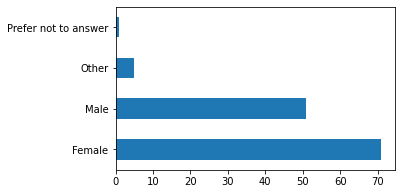

In [13]:
respondent_df['gender'] = respondent_df.Q_demos_gender.map(recode_values['Q_demos_gender'])
fig,ax = plt.subplots(figsize=(5,3))
respondent_df['gender'].value_counts().plot.barh(ax=ax)
respondent_df['gender'].value_counts()

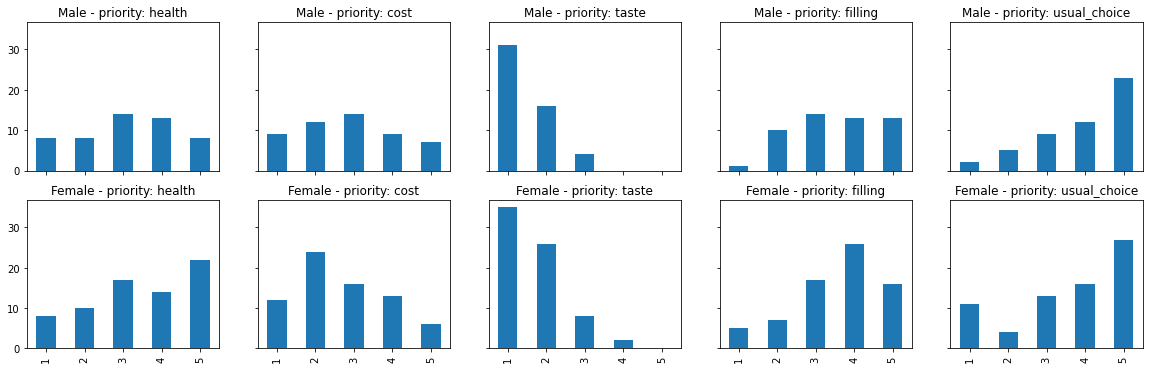

In [16]:
priorities_N = len(recode_values['Q_priorities'])
fig, axes = plt.subplots(2, priorities_N, figsize=(4*priorities_N, 3*2), sharey=True, sharex=True)
for g, gender in enumerate(['Male','Female']):
    g_df = respondent_df[respondent_df['gender']==gender]
    for i, (p, priority) in enumerate(recode_values['Q_priorities'].items()):
        Q_priority = 'Q_priorities_%s'%p
        ax = axes[g][i]
        ax.set_title('%s - priority: %s' % (gender, priority))
        g_df[Q_priority].value_counts().sort_index().plot.bar(ax=ax)
    


Strongly Democratic    27
Democratic             28
Lean Democratic        37
Lean Republican        22
Republican             13
Strongly Republican     1
Name: Q_politics, dtype: int64


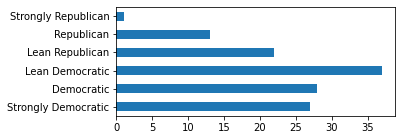

In [17]:
fig,ax = plt.subplots(figsize=(5,2))
respondent_df.Q_politics.value_counts().sort_index().rename(recode_values['Q_politics']).plot.barh(ax=ax)
print(respondent_df.Q_politics.value_counts().sort_index().rename(recode_values['Q_politics']))

In [18]:
respondent_df['Q_urban'] = respondent_df['Q_urban'].map(recode_values['Q_urban'])

Suburban    66
Urban       35
Rural       27
Name: Q_urban, dtype: int64

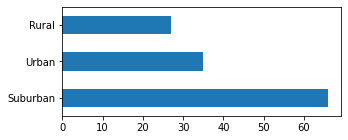

In [28]:
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_urban'].value_counts().plot.barh(ax=ax)
respondent_df['Q_urban'].value_counts()

In [29]:
respondent_df.Q_past_vegetarian.map(recode_values['Q_past_vegetarian']).describe()

count    128.000000
mean       4.914062
std        2.209597
min        0.000000
25%        4.000000
50%        5.000000
75%        7.000000
max        7.000000
Name: Q_past_vegetarian, dtype: float64

In [30]:
respondent_df.Q_past_vegan.map(recode_values['Q_past_vegan']).describe()

count    128.000000
mean       6.085938
std        1.531955
min        0.000000
25%        5.000000
50%        7.000000
75%        7.000000
max        7.000000
Name: Q_past_vegan, dtype: float64

IndexError: index 0 is out of bounds for axis 0 with size 0

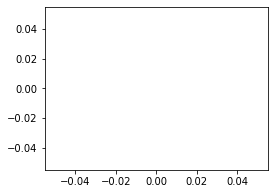

In [31]:
fig,ax = plt.subplots(figsize=(4,3))
respondent_df.Q_urban.map(recode_values['Q_urban']).value_counts().sort_index().plot.barh(ax=ax)
print(respondent_df.Q_urban.map(recode_values['Q_urban']).value_counts().sort_index())

None           103
Vegetarian       7
Gluten free      5
Vegan            4
Other            4
Pescatarian      2
Keto             1
Name: Q_special_diet, dtype: int64


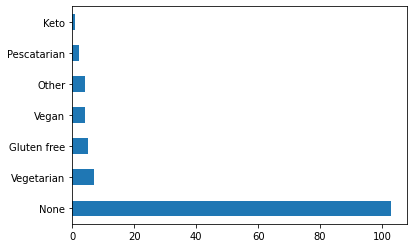

In [32]:
respondent_df.Q_special_diet.map(recode_values['Q_special_diet']).value_counts().plot.barh()
print(respondent_df.Q_special_diet.map(recode_values['Q_special_diet']).value_counts())

In [33]:
"""
Add in diet specific varaibles:
diet_vegetarian
diet_vegan
diet_veg : (is_vegetarian|is_vegan)
diet_other : said had a special diet that is not veg
diet_none : answered None for special diet
"""
respondent_df['diet_vegetarian'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: '3' in d)
respondent_df['diet_vegan'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: '5' in d)
respondent_df['diet_veg'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: ('3' in d) or ('5' in d))
respondent_df['diet_other'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: ('3' not in d) and ('5' not in d) and ('7' not in d))
respondent_df['diet_none'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: '7' in d)
respondent_df['diet_none'].sum()

103

In [34]:
print('veg genders')
respondent_df[respondent_df['diet_veg']][['Q_demos_gender']].value_counts()

veg genders


Q_demos_gender
1                 5
2                 5
3                 1
dtype: int64

In [35]:
respondent_df.Q_past_vegan.value_counts()

1     81
5     16
4     13
6     11
10     3
8      2
7      2
Name: Q_past_vegan, dtype: int64

1    36
2    36
3    37
4    15
5     4
Name: Q_reduce_meat, dtype: int64
Never        36
Rarely       36
Sometimes    37
Often        15
Always        4
Name: Q_reduce_meat, dtype: int64


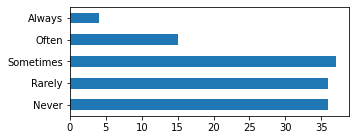

In [36]:
print(respondent_df['Q_reduce_meat'].value_counts().sort_index())
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_reduce_meat'].value_counts().sort_index().rename(recode_values['Q_reduce_meat']).plot.barh(ax=ax)
print(respondent_df['Q_reduce_meat'].value_counts().sort_index().rename(recode_values['Q_reduce_meat']))

non-veg only
1    35
2    35
3    36
4    11
Name: Q_reduce_meat, dtype: int64
Never        35
Rarely       35
Sometimes    36
Often        11
Name: Q_reduce_meat, dtype: int64


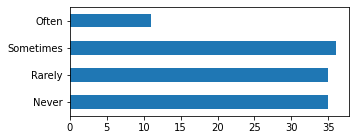

In [37]:
print('non-veg only')
print(respondent_df[respondent_df['diet_veg']==False]['Q_reduce_meat'].value_counts().sort_index())
fig,ax = plt.subplots(figsize=(5,2))
respondent_df[respondent_df['diet_veg']==False]['Q_reduce_meat'].value_counts().sort_index().rename(recode_values['Q_reduce_meat']).plot.barh(ax=ax)
print(respondent_df[respondent_df['diet_veg']==False]['Q_reduce_meat'].value_counts().sort_index().rename(recode_values['Q_reduce_meat']))

Q_how_important_env
1     4
2     5
3    20
4    67
5    32
Name: Q_how_important_env, dtype: int64
Very much not important     4
Not important               5
Neutral                    20
Somewhat important         67
Very important             32
Name: Q_how_important_env, dtype: int64


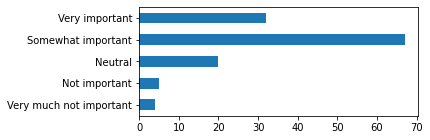

In [38]:
print('Q_how_important_env')
print(respondent_df['Q_how_important_env'].value_counts().sort_index())
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_how_important_env'].value_counts().sort_index().rename(recode_values['Q_how_important_env']).plot.barh(ax=ax)
print(respondent_df['Q_how_important_env'].value_counts().sort_index().rename(recode_values['Q_how_important_env']))

Q_good_for_env
1    26
2    58
3    37
4     5
5     2
Name: Q_good_for_env, dtype: int64
Strongly agree       26
Agree                58
Neutral              37
Disagree              5
Strongly disagree     2
Name: Q_good_for_env, dtype: int64


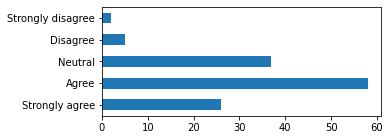

In [39]:
print('Q_good_for_env')
print(respondent_df['Q_good_for_env'].value_counts().sort_index())
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_good_for_env'].value_counts().sort_index().rename(recode_values['Q_good_for_env']).plot.barh(ax=ax)
print(respondent_df['Q_good_for_env'].value_counts().sort_index().rename(recode_values['Q_good_for_env']))

### Menu choices table

```
ResponseId, labeled (0/1), QID, menu (sandwich/pata), choice_type (1-5), choice (1,2) 
```

In [40]:
# Wide data
choices_wide_df = (df[['ResponseId'] + choice_Qs].drop([0,1]))
# drop data from respondents who failed attention checks
choices_wide_df = choices_wide_df[
    (choices_wide_df.ResponseId.isin(passed_attn_checks_ResponseId_list))
]
choices_wide_df.head(3)

,ResponseId,Q_pasta_1_unlabeled,Q_pasta_2_unlabeled,Q_pasta_3_unlabeled,Q_pasta_4_unlabeled,Q_pasta_5_unlabeled,Q_sandwich_1,Q_sandwich_2,Q_sandwich_3,Q_sandwich_4,...,Q_pasta_1_labeled,Q_pasta_2_labeled,Q_pasta_3_labeled,Q_pasta_4_labeled,Q_pasta_5_labeled,Q_sandwich_1_labeled,Q_sandwich_2_labeled,Q_sandwich_3_labeled,Q_sandwich_4_labeled,Q_sandwich_5_labeled
3,R_3I4OtkJA2u88n7O,NaN,1,2,2,1,2,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,R_2azWqLxVBzcA2KZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,1,2,1,NaN,2,1,NaN,2,2
6,R_10IsfPbYwY0wERg,2,1,NaN,1,1,2,2,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Transform the wide data to long data.
choices_df = pd.melt(choices_wide_df, 
                     id_vars=['ResponseId'], value_vars=choice_Qs, 
                     var_name='QID', value_name='choice')
choices_df.head()

,ResponseId,QID,choice
0,R_3I4OtkJA2u88n7O,Q_pasta_1_unlabeled,NaN
1,R_2azWqLxVBzcA2KZ,Q_pasta_1_unlabeled,NaN
2,R_10IsfPbYwY0wERg,Q_pasta_1_unlabeled,2
3,R_1n1pb9SbHwD3XOr,Q_pasta_1_unlabeled,NaN
4,R_3iExvfnLn47ukrC,Q_pasta_1_unlabeled,NaN


In [42]:
# Add Q data
# ResponseId, labeled (0/1), QID, menu (sandwich/pata), choice_type (1-5), choice (1,2) 
choices_df['menu'] = choices_df['QID'].apply(lambda QID: QID.split('_')[1])
choices_df['choice_type'] = choices_df['QID'].apply(lambda QID: QID.split('_')[2])
choices_df['labeled'] = choices_df['QID'].apply(lambda QID: 1 if len(QID.split('_')) > 3 and QID.split('_')[3] == 'labeled' else 0)
# only keep responses for answered questions
print('dropping unanswered Qs; respondents answer %s = %s/%s of total Qs' % (
    len(choices_df.dropna())/len(choices_df), len(choices_df.dropna()), len(choices_df)
))
choices_df = choices_df.dropna()
choices_df.head()

dropping unanswered Qs; respondents answer 0.4 = 976/2440 of total Qs


,ResponseId,QID,choice,menu,choice_type,labeled
2,R_10IsfPbYwY0wERg,Q_pasta_1_unlabeled,2,pasta,1,0
6,R_1NhbuKqiEsRy2DD,Q_pasta_1_unlabeled,1,pasta,1,0
7,R_3hmWa2jK7lzK0ub,Q_pasta_1_unlabeled,2,pasta,1,0
10,R_3qW4GUVHVpDPZNv,Q_pasta_1_unlabeled,2,pasta,1,0
11,R_2P5UFinveb1H6gh,Q_pasta_1_unlabeled,1,pasta,1,0


In [43]:
# make choice 0/1. choice currently coded as 1: X (labeled); 2: Y 
# relabel to change value of 2 (Y)
# 1: X (labeled) 0: Y
choices_df['choice'] = choices_df['choice'].apply(lambda c: 1 if int(c) == 1 else 0)
choices_df.head()

,ResponseId,QID,choice,menu,choice_type,labeled
2,R_10IsfPbYwY0wERg,Q_pasta_1_unlabeled,0,pasta,1,0
6,R_1NhbuKqiEsRy2DD,Q_pasta_1_unlabeled,1,pasta,1,0
7,R_3hmWa2jK7lzK0ub,Q_pasta_1_unlabeled,0,pasta,1,0
10,R_3qW4GUVHVpDPZNv,Q_pasta_1_unlabeled,0,pasta,1,0
11,R_2P5UFinveb1H6gh,Q_pasta_1_unlabeled,1,pasta,1,0


## Invalid simple model

Warning:  just messing around here!
- not controlling for effects by ResponseId -- mixing the many responses per ResponseId together
- mixing all of the choice types together


In [44]:
simple_model = smf.logit("choice ~ labeled", data=choices_df).fit()
print(simple_model.summary())

Optimization terminated successfully.
         Current function value: 0.689626
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  976
Model:                          Logit   Df Residuals:                      974
Method:                           MLE   Df Model:                            1
Date:                Fri, 24 Jun 2022   Pseudo R-squ.:                0.003037
Time:                        15:36:28   Log-Likelihood:                -673.08
converged:                       True   LL-Null:                       -675.13
Covariance Type:            nonrobust   LLR p-value:                   0.04286
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0250      0.091      0.274      0.784      -0.154       0.204
labeled       -0.2599      0.

In [45]:
simple_model_odds = pd.DataFrame(np.exp(simple_model.params), columns=['OR'])
simple_model_odds['z-value'] = simple_model.pvalues
simple_model_odds[['2.5%', '97.5%']] = np.exp(simple_model.conf_int())
print(simple_model_odds)

                 OR   z-value     2.5%     97.5%
Intercept  1.025316  0.784197  0.85733  1.226218
labeled    0.771092  0.043072  0.59942  0.991931


## Main effects by comparison type

In [46]:
for choice_type in choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ---------\n' % choice_type)
    c_df = choices_df[choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ---------

Optimization terminated successfully.
         Current function value: 0.656433
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  194
Model:                          Logit   Df Residuals:                      192
Method:                           MLE   Df Model:                            1
Date:                Fri, 24 Jun 2022   Pseudo R-squ.:               0.0005294
Time:                        15:37:15   Log-Likelihood:                -127.35
converged:                       True   LL-Null:                       -127.42
Covariance Type:            nonrobust   LLR p-value:                    0.7134
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4940      0.211     -2.336      0.019     

Just pasta

In [47]:
for choice_type in choices_df.choice_type.unique():
    print('\n-------- Model for menu: pasta; comparison type: %s ---------\n' % choice_type)
    c_df = choices_df[(choices_df.menu == 'pasta') & (choices_df.choice_type == choice_type)]
    choice_type_model = smf.logit("choice ~ labeled", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for menu: pasta; comparison type: 1 ---------

Optimization terminated successfully.
         Current function value: 0.661735
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                   98
Model:                          Logit   Df Residuals:                       96
Method:                           MLE   Df Model:                            1
Date:                Fri, 24 Jun 2022   Pseudo R-squ.:                0.001686
Time:                        15:37:48   Log-Likelihood:                -64.850
converged:                       True   LL-Null:                       -64.960
Covariance Type:            nonrobust   LLR p-value:                    0.6397
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6008      0.302     -1.991  

In [51]:
choices_type_names_dict = {
    '1':'1=(labeled) vegetarian vs 0=meat',
    '2':'1=(labeled) vegan vs 0=meat',
    '3':'1=(labeled) vegetarian vs 0=vegetarian',
    '4':'1=(labeled) vegan vs 0=vegan',
    '5':'1=(labeled) vegan vs 0=vegetarian',
}

Test with diet_veg as moderator

In [52]:
choices_df['diet_veg'] = choices_df.ResponseId.map(respondent_df.set_index('ResponseId')['diet_veg'])

In [53]:
for choice_type in choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (choice_type,choices_type_names_dict[choice_type]))
    c_df = choices_df[choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + diet_veg + labeled:diet_veg", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.611326
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  194
Model:                          Logit   Df Residuals:                      190
Method:                           MLE   Df Model:                            3
Date:                Fri, 24 Jun 2022   Pseudo R-squ.:                 0.06921
Time:                        15:38:13   Log-Likelihood:                -118.60
converged:                       True   LL-Null:                       -127.42
Covariance Type:            nonrobust   LLR p-value:                 0.0005226
                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

Comparison type and gender

In [54]:
response_genders = respondent_df.set_index('ResponseId')['Q_demos_gender']
# response_genders

In [55]:
choices_df['male'] = choices_df['ResponseId'].apply(lambda r: 1 if response_genders[r]=='1' else 0)
# choices_df

In [56]:
for choice_type in choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (choice_type,choices_type_names_dict[choice_type]))
    c_df = choices_df[choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + labeled:male", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.607282
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  194
Model:                          Logit   Df Residuals:                      190
Method:                           MLE   Df Model:                            3
Date:                Fri, 24 Jun 2022   Pseudo R-squ.:                 0.07537
Time:                        15:38:29   Log-Likelihood:                -117.81
converged:                       True   LL-Null:                       -127.42
Covariance Type:            nonrobust   LLR p-value:                 0.0002479
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.

Test for: Test for sandwich only, for non-veg

In [59]:
menu_sandwich = 'sandwich'
def get_sandwich_non_veg_choices_df(df):
    return df[(df.menu == menu_sandwich) & (choices_df.diet_veg==False)]

In [60]:
# without interaction
non_veg_sandwich_choices_df = get_sandwich_non_veg_choices_df(choices_df)
for choice_type in non_veg_sandwich_choices_df.choice_type.unique():
    print('menu: %s; non-veg' % menu_sandwich)
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_sandwich_choices_df[non_veg_sandwich_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)

menu: sandwich; non-veg

-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.609118
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                   89
Model:                          Logit   Df Residuals:                       87
Method:                           MLE   Df Model:                            1
Date:                Fri, 24 Jun 2022   Pseudo R-squ.:                0.007456
Time:                        15:38:55   Log-Likelihood:                -54.211
converged:                       True   LL-Null:                       -54.619
Covariance Type:            nonrobust   LLR p-value:                    0.3668
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

Test for: Test for sandwich only, by gender, for non-veg

In [61]:
# without interaction
non_veg_sandwich_choices_df = get_sandwich_non_veg_choices_df(choices_df)
for choice_type in non_veg_sandwich_choices_df.choice_type.unique():
    print('menu: %s; non-veg' % menu_sandwich)
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_sandwich_choices_df[non_veg_sandwich_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)

menu: sandwich; non-veg

-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.568226
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                   89
Model:                          Logit   Df Residuals:                       86
Method:                           MLE   Df Model:                            2
Date:                Fri, 24 Jun 2022   Pseudo R-squ.:                 0.07409
Time:                        15:39:07   Log-Likelihood:                -50.572
converged:                       True   LL-Null:                       -54.619
Covariance Type:            nonrobust   LLR p-value:                   0.01748
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [62]:
# with interaction
non_veg_sandwich_choices_df = get_sandwich_non_veg_choices_df(choices_df)
for choice_type in non_veg_sandwich_choices_df.choice_type.unique():
    print('menu: %s; non-veg' % menu_sandwich)
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_sandwich_choices_df[non_veg_sandwich_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + labeled:male", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)

menu: sandwich; non-veg

-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.563352
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                   89
Model:                          Logit   Df Residuals:                       85
Method:                           MLE   Df Model:                            3
Date:                Fri, 24 Jun 2022   Pseudo R-squ.:                 0.08203
Time:                        15:39:07   Log-Likelihood:                -50.138
converged:                       True   LL-Null:                       -54.619
Covariance Type:            nonrobust   LLR p-value:                   0.02982
                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

Test with priority:health as a moderator, using whether health rated in top 2 priorities

In [63]:
Q_priorities_col_map = {'Q_priorities_%s'%k:'Q_priorities_%s'%v for k,v in recode_values['Q_priorities'].items()}
# Q_priorities_col_map

In [64]:
# whether health in top 1-2 priorities
choices_df['priority_health'] = choices_df['ResponseId'].map(respondent_df.set_index('ResponseId').rename(
    columns=Q_priorities_col_map
)['Q_priorities_health'].apply(lambda h: 1 if h in ['1','2'] else 0))
# choices_df['priority_health']

In [65]:
non_veg_sandwich_choices_df = get_sandwich_non_veg_choices_df(choices_df)
for choice_type in non_veg_sandwich_choices_df.choice_type.unique():
    print('\nmenu: %s; non-veg' % menu_sandwich)
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_sandwich_choices_df[non_veg_sandwich_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit(
        "choice ~ labeled + male + priority_health + labeled:male + labeled:priority_health", 
        data=c_df
    ).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


menu: sandwich; non-veg

-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.452382
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                   89
Model:                          Logit   Df Residuals:                       83
Method:                           MLE   Df Model:                            5
Date:                Fri, 24 Jun 2022   Pseudo R-squ.:                  0.2629
Time:                        15:39:09   Log-Likelihood:                -40.262
converged:                       True   LL-Null:                       -54.619
Covariance Type:            nonrobust   LLR p-value:                 2.639e-05
                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

With political leaning as moderator (looking at sandwich menu, non-veg only)

In [66]:
choices_df['politics'] = \
    choices_df['ResponseId'].map(respondent_df.set_index('ResponseId')['Q_politics'].astype(float))
choices_df['politics'].describe()

count    976.000000
mean       2.770492
std        1.298753
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        6.000000
Name: politics, dtype: float64

In [67]:
non_veg_sandwich_choices_df = get_sandwich_non_veg_choices_df(choices_df)
for choice_type in choices_df.choice_type.unique():
    print('\nmenu: %s; non-veg' % menu_sandwich)
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (choice_type,choices_type_names_dict[choice_type]))
    c_df = non_veg_sandwich_choices_df[non_veg_sandwich_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + politics + labeled:politics", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


menu: sandwich; non-veg

-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.595700
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                   89
Model:                          Logit   Df Residuals:                       85
Method:                           MLE   Df Model:                            3
Date:                Fri, 24 Jun 2022   Pseudo R-squ.:                 0.02932
Time:                        15:39:13   Log-Likelihood:                -53.017
converged:                       True   LL-Null:                       -54.619
Covariance Type:            nonrobust   LLR p-value:                    0.3614
                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

In [68]:
non_veg_sandwich_choices_df = get_sandwich_non_veg_choices_df(choices_df)
for choice_type in choices_df.choice_type.unique():
    print('\nmenu: %s; non-veg' % menu_sandwich)
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (choice_type,choices_type_names_dict[choice_type]))
    c_df = non_veg_sandwich_choices_df[non_veg_sandwich_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + politics + labeled:politics", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


menu: sandwich; non-veg

-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.545814
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                   89
Model:                          Logit   Df Residuals:                       84
Method:                           MLE   Df Model:                            4
Date:                Fri, 24 Jun 2022   Pseudo R-squ.:                  0.1106
Time:                        15:39:18   Log-Likelihood:                -48.577
converged:                       True   LL-Null:                       -54.619
Covariance Type:            nonrobust   LLR p-value:                   0.01675
                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

With urban as moderator (menu: sandwich; non-veg only)

In [85]:
choices_df['lives_urban'] = choices_df['ResponseId'].map(respondent_df.set_index('ResponseId')['Q_urban'].apply(lambda u: 1 if u == 'Urban' else 0))
# choices_df['lives_urban']

In [84]:
non_veg_sandwich_choices_df = get_sandwich_non_veg_choices_df(choices_df)
for choice_type in choices_df.choice_type.unique():
    print('\nmenu: %s; non-veg' % menu_sandwich)
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (choice_type,choices_type_names_dict[choice_type]))
    c_df = non_veg_sandwich_choices_df[non_veg_sandwich_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + lives_urban + labeled:lives_urban", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


menu: sandwich; non-veg

-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.606559
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                   89
Model:                          Logit   Df Residuals:                       85
Method:                           MLE   Df Model:                            3
Date:                Fri, 24 Jun 2022   Pseudo R-squ.:                 0.01163
Time:                        15:42:43   Log-Likelihood:                -53.984
converged:                       True   LL-Null:                       -54.619
Covariance Type:            nonrobust   LLR p-value:                    0.7363
                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

## Power analysis to help determine sample size

In [86]:
# Borrowed from https://stackoverflow.com/questions/15204070/is-there-a-python-scipy-function-to-determine-parameters-needed-to-obtain-a-ta
from scipy.stats import norm, zscore

def sample_power_probtest(p1, p2, power=0.8, sig=0.05):
    z = norm.isf([sig/2]) #two-sided t test
    zp = -1 * norm.isf([power]) 
    d = (p1-p2)
    s =2*((p1+p2) /2)*(1-((p1+p2) /2))
    n = s * ((zp + z)**2) / (d**2)
    return int(round(n[0]))

In [87]:
def get_sample_n(choices_df, choice_type, power=0.8, sig=0.05, verbose=False):
    c_df = choices_df[(choices_df.choice_type == choice_type)]
    c_labeled_df = c_df[c_df.labeled == 1]
    c_unlabeled_df = c_df[c_df.labeled == 0]
    c_labeled_choice_counts = c_labeled_df.groupby('choice').count()['ResponseId']
    p_labeled = c_labeled_choice_counts[1] / c_labeled_choice_counts.sum()
    c_unlabeled_choice_counts = c_unlabeled_df.groupby('choice').count()['ResponseId']
    p_unlabeled = c_unlabeled_choice_counts[1] / c_unlabeled_choice_counts.sum()
    n = sample_power_probtest(p_labeled, p_unlabeled, power=power, sig=sig)
    if verbose:
        print('labeled:', c_labeled_choice_counts)
        print('p(choose X=1) ', p_labeled)
        print('unlabeled:', c_unlabeled_choice_counts)
        print('p(choose X=1) ', p_unlabeled)
        print('\nsample power test n = %s' % n)
    return (n, p_labeled, p_unlabeled)
    

choice type: 1
sample power test n = 5642
choice type: 2
sample power test n = 734
choice type: 3
sample power test n = 355
choice type: 4
sample power test n = 316
choice type: 5
sample power test n = 42692


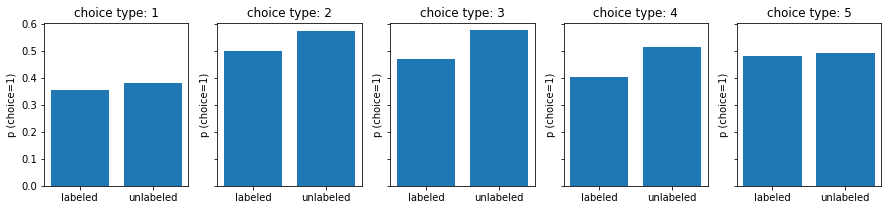

In [88]:
choice_types = choices_df.choice_type.unique()
fig, ax = plt.subplots(1, len(choice_types), figsize=(3*len(choice_types),3), sharey=True)
for i, choice_type in enumerate(choice_types):
    c_df = choices_df[(choices_df.choice_type == choice_type)]
    print('choice type: %s' % (choice_type))
    (n, p_labeled, p_unlabeled) = get_sample_n(c_df, choice_type)
    print('sample power test n = %s' % n)
    ax[i].set_ylabel('p (choice=1)')
    ax[i].set_title('choice type: %s' % (choice_type))
    ax[i].bar(['labeled','unlabeled'], [p_labeled,p_unlabeled])

menu: pasta choice type: 1
sample power test n = 1755
menu: pasta choice type: 2
sample power test n = 338
menu: pasta choice type: 3
sample power test n = 267
menu: pasta choice type: 4
sample power test n = 371
menu: pasta choice type: 5
sample power test n = 740
menu: sandwich choice type: 1
sample power test n = 373
menu: sandwich choice type: 2
sample power test n = 2449
menu: sandwich choice type: 3
sample power test n = 267
menu: sandwich choice type: 4
sample power test n = 272
menu: sandwich choice type: 5
sample power test n = 1333


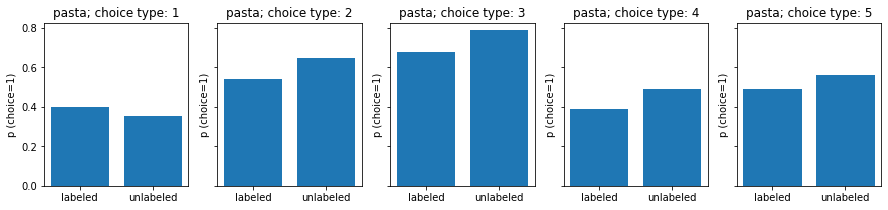

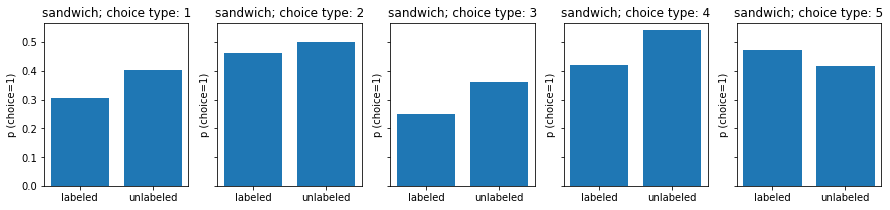

In [89]:
for menu in ['pasta', 'sandwich']:
    choice_types = choices_df.choice_type.unique()
    fig, ax = plt.subplots(1, len(choice_types), figsize=(3*len(choice_types),3), sharey=True)
    for i, choice_type in enumerate(choice_types):
        c_df = choices_df[(choices_df.menu == menu) & (choices_df.choice_type == choice_type)]
        print('menu: %s choice type: %s' % (menu, choice_type))
        (n, p_labeled, p_unlabeled) = get_sample_n(c_df, choice_type)
        print('sample power test n = %s' % n)
        ax[i].set_ylabel('p (choice=1)')
        ax[i].set_title('%s; choice type: %s' % (menu,choice_type))
        ax[i].bar(['labeled','unlabeled'], [p_labeled,p_unlabeled])


------ gender: male -------

choice type: 1
sample power test n = 98
choice type: 2
sample power test n = 49
choice type: 3
sample power test n = 1468
choice type: 4
sample power test n = 87
choice type: 5
sample power test n = 2382

------ gender: female -------

choice type: 1
sample power test n = 3297
choice type: 2
sample power test n = 45755
choice type: 3
sample power test n = 68
choice type: 4
sample power test n = 196022
choice type: 5
sample power test n = 1345


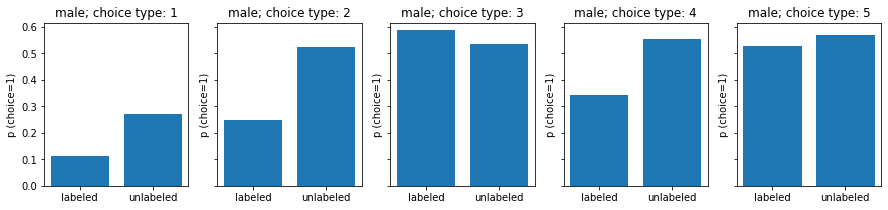

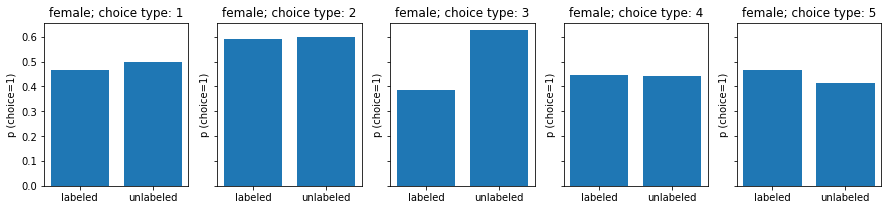

In [90]:
gender = {'1':'male','2':'female'}

for gender_code, gender in gender.items():
    print('\n------ gender: %s -------\n' % gender)
    g_responseIds = respondent_df[respondent_df['Q_demos_gender']==gender_code].ResponseId
    g_choices_df = choices_df[choices_df.ResponseId.isin(g_responseIds)]
    choice_types = g_choices_df.choice_type.unique()
    fig, ax = plt.subplots(1, len(choice_types), figsize=(3*len(choice_types),3), sharey=True)
    for i, choice_type in enumerate(choice_types):
        c_df = g_choices_df[(g_choices_df.choice_type == choice_type)]
        print('choice type: %s' % (choice_type))
        (n, p_labeled, p_unlabeled) = get_sample_n(c_df, choice_type)
        print('sample power test n = %s' % n)
        ax[i].set_ylabel('p (choice=1)')
        ax[i].set_title('%s; choice type: %s' % (gender, choice_type))
        ax[i].bar(['labeled','unlabeled'], [p_labeled, p_unlabeled])

By gender, for non-veg


------ gender: male -------

choice type: 1
sample power test n = 201
choice type: 2
sample power test n = 79
choice type: 3
sample power test n = 612
choice type: 4
sample power test n = 60
choice type: 5
sample power test n = 2670

------ gender: female -------

choice type: 1
sample power test n = 3619
choice type: 2
sample power test n = 48691
choice type: 3
sample power test n = 64
choice type: 4
sample power test n = 33456
choice type: 5
sample power test n = 7266


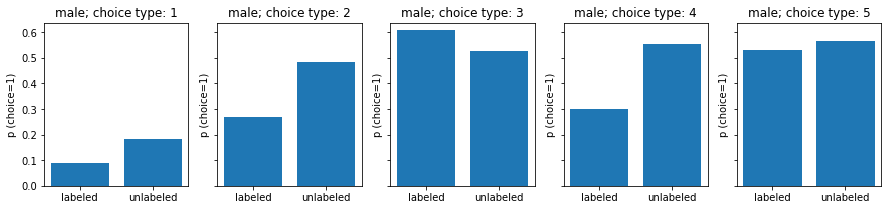

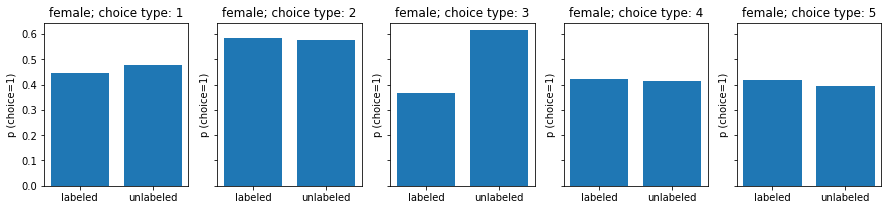

In [91]:
gender = {'1':'male','2':'female'}

for gender_code, gender in gender.items():
    print('\n------ gender: %s -------\n' % gender)
    g_responseIds = respondent_df[respondent_df['Q_demos_gender']==gender_code].ResponseId
    g_choices_df = choices_df[choices_df.ResponseId.isin(g_responseIds) & (choices_df.diet_veg == False)]
    choice_types = g_choices_df.choice_type.unique()
    fig, ax = plt.subplots(1, len(choice_types), figsize=(3*len(choice_types),3), sharey=True)
    for i, choice_type in enumerate(choice_types):
        c_df = g_choices_df[(g_choices_df.choice_type == choice_type)]
        print('choice type: %s' % (choice_type))
        (n, p_labeled, p_unlabeled) = get_sample_n(c_df, choice_type)
        print('sample power test n = %s' % n)
        ax[i].set_ylabel('p (choice=1)')
        ax[i].set_title('%s; choice type: %s' % (gender, choice_type))
        ax[i].bar(['labeled','unlabeled'], [p_labeled, p_unlabeled])

By menu and gender for non-veg


------ menu: pasta; gender: male -------

choice type: 1
sample power test n = 1178
choice type: 2
sample power test n = 47698
choice type: 3
sample power test n = 143
choice type: 4
sample power test n = 80
choice type: 5
sample power test n = 126

------ menu: pasta; gender: female -------

choice type: 1
sample power test n = 18209
choice type: 2
sample power test n = 120
choice type: 3
sample power test n = 39
choice type: 4
sample power test n = 15019
choice type: 5
sample power test n = 11440

------ menu: sandwich; gender: male -------

choice type: 1
sample power test n = 75
choice type: 2
sample power test n = 18
choice type: 3
sample power test n = 6259
choice type: 4
sample power test n = 51
choice type: 5
sample power test n = 400

------ menu: sandwich; gender: female -------

choice type: 1
sample power test n = 623
choice type: 2
sample power test n = 117
choice type: 3
sample power test n = 58
choice type: 4
sample power test n = 13198
choice type: 5
sample power test 

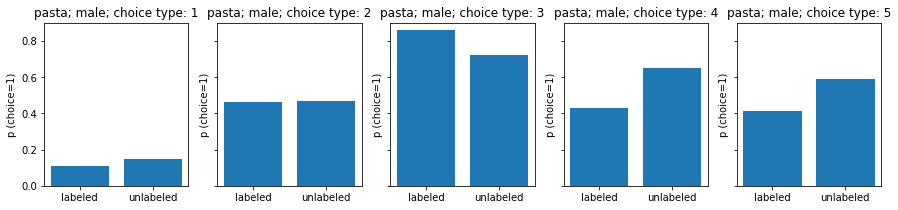

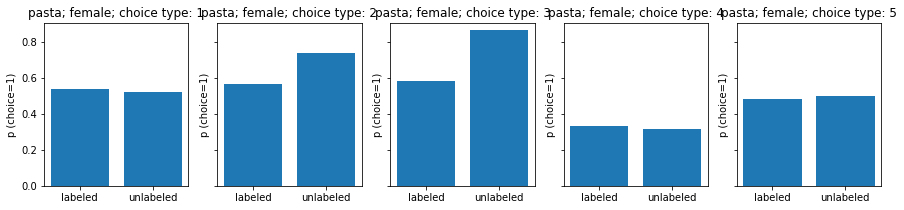

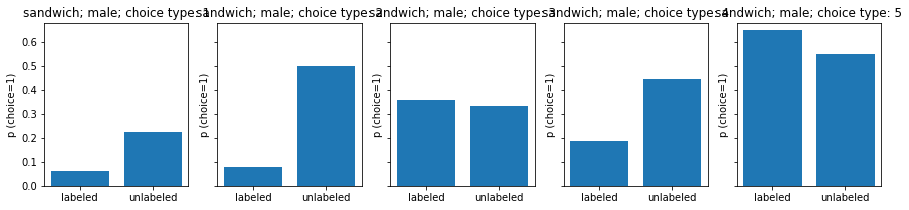

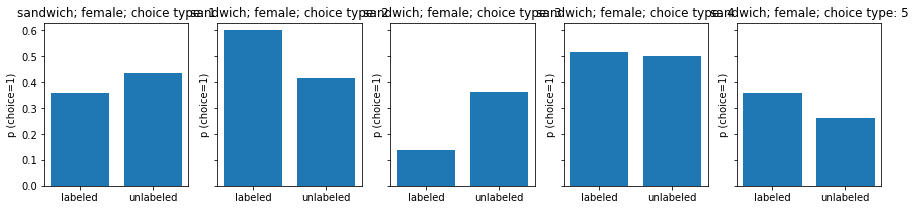

In [92]:
gender_map = {'1':'male','2':'female'}
for menu in ['pasta', 'sandwich']:
    for gender_code, gender in gender_map.items():
        print('\n------ menu: %s; gender: %s -------\n' % (menu,gender))
        g_responseIds = respondent_df[respondent_df['Q_demos_gender']==gender_code].ResponseId
        g_choices_df = choices_df[(
            choices_df.ResponseId.isin(g_responseIds) & \
            (choices_df.diet_veg == False) & \
            (choices_df.menu == menu)
        )]
        choice_types = g_choices_df.choice_type.unique()
        fig, ax = plt.subplots(1, len(choice_types), figsize=(3*len(choice_types),3), sharey=True)
        for i, choice_type in enumerate(choice_types):
            c_df = g_choices_df[(g_choices_df.choice_type == choice_type)]
            print('choice type: %s' % (choice_type))
            (n, p_labeled, p_unlabeled) = get_sample_n(c_df, choice_type)
            print('sample power test n = %s' % n)
            ax[i].set_ylabel('p (choice=1)')
            ax[i].set_title('%s; %s; choice type: %s' % (menu,gender, choice_type))
            ax[i].bar(['labeled','unlabeled'], [p_labeled, p_unlabeled])